# Installing dependencies

In [1]:
!pip install node2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 39.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
mlxte

# Imports

In [2]:
import os
import random

#Data
import numpy as np
import pandas as pd
import re
import json
import math

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import networkx as nx
from tqdm import tqdm

# Models
from kaggle_secrets import UserSecretsClient
from openai import AzureOpenAI
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from node2vec import Node2Vec
import torch
import torch.nn as nn
import torch.nn.functional as F
import umap

#Metrics
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

#Transformations
from sklearn.preprocessing import normalize
import networkx as nx
from itertools import combinations
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
from itertools import combinations
from collections import Counter
import ast

2025-07-08 02:47:11.074292: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751942831.328439      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751942831.405517      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Policy Embeddings
In this notebook, I vectorized each nation's political stance by:
- cleaning text
- embedding country speeches with semantic segmentation and averaging
- graph based knowledge embedding utilzied country information such as: political bloc, voting record
- combining vectors

# Cleaning Text

In [3]:
# Function for cleaning data

def clean_text(text: str) -> str:
    """Clean text by removing country names while preserving stopwords"""
    print("Cleaning text")
    country_names = [
        "Afghanistan", "Albania", "Algeria", "Andorra", "Angola", 
        "Antigua", "Argentina", "Armenia", "Australia", "Austria",
        "Azerbaijan", "Bahamas", "Bahrain", "Bangladesh", "Barbados",
        "Belarus", "Belgium", "Belize", "Benin", "Bhutan",
        "Bolivia", "Bosnia", "Botswana", "Brazil", "Brunei",
        "Bulgaria", "Burkina", "Burundi", "Cambodia", "Cameroon",
        "Canada", "Cape Verde", "Central African Republic", "Chad", "Chile",
        "China", "Colombia", "Comoros", "Congo", "Costa Rica",
        "Croatia", "Cuba", "Cyprus", "Czech Republic", "Denmark",
        "Djibouti", "Dominica", "Dominican Republic", "Ecuador", "Egypt",
        "El Salvador", "Equatorial Guinea", "Eritrea", "Estonia", "Eswatini",
        "Ethiopia", "Fiji", "Finland", "France", "Gabon",
        "Gambia", "Georgia", "Germany", "Ghana", "Greece",
        "Grenada", "Guatemala", "Guinea", "Guinea-Bissau", "Guyana",
        "Haiti", "Honduras", "Hungary", "Iceland", "India",
        "Indonesia", "Iran", "Iraq", "Ireland", "Israel",
        "Italy", "Ivory Coast", "Jamaica", "Japan", "Jordan",
        "Kazakhstan", "Kenya", "Kiribati", "Korea", "Kosovo",
        "Kuwait", "Kyrgyzstan", "Laos", "Latvia", "Lebanon",
        "Lesotho", "Liberia", "Libya", "Liechtenstein", "Lithuania",
        "Luxembourg", "Madagascar", "Malawi", "Malaysia", "Maldives",
        "Mali", "Malta", "Marshall Islands", "Mauritania", "Mauritius",
        "Mexico", "Micronesia", "Moldova", "Monaco", "Mongolia",
        "Montenegro", "Morocco", "Mozambique", "Myanmar", "Namibia",
        "Nauru", "Nepal", "Netherlands", "New Zealand", "Nicaragua",
        "Niger", "Nigeria", "North Korea", "North Macedonia", "Norway",
        "Oman", "Pakistan", "Palau", "Panama", "Papua New Guinea",
        "Paraguay", "Peru", "Philippines", "Poland", "Portugal",
        "Qatar", "Romania", "Russia", "Rwanda", "Saint Kitts",
        "Saint Lucia", "Saint Vincent", "Samoa", "San Marino", "Sao Tome",
        "Saudi Arabia", "Senegal", "Serbia", "Seychelles", "Sierra Leone",
        "Singapore", "Slovakia", "Slovenia", "Solomon Islands", "Somalia",
        "South Africa", "South Korea", "South Sudan", "Spain", "Sri Lanka",
        "Sudan", "Suriname", "Sweden", "Switzerland", "Syria",
        "Taiwan", "Tajikistan", "Tanzania", "Thailand", "Timor-Leste",
        "Togo", "Tonga", "Trinidad", "Tunisia", "Turkey",
        "Turkmenistan", "Tuvalu", "Uganda", "Ukraine", "United Arab Emirates",
        "United Kingdom", "United States", "Uruguay", "Uzbekistan", "Vanuatu",
        "Vatican City", "Venezuela", "Vietnam", "Yemen", "Zambia", "Zimbabwe"
    ]
    
    country_names += [
        "USA", "UK", "UAE", "PRC", "DPRK", 
        "ROK", "DRC", "U.S.", "U.K.", "America",
        "Britain", "England", "Scotland", "Wales", "Northern Ireland",
        "Hong Kong", "Macau", "Palestine", "Ivory Coast", "Czechia",
        "Macedonia", "Swaziland", "Burma", "East Timor", "Vatican"
    ]
    text = re.sub(r'\b(?:the\s+)?(?:delegation\s+of\s+)?(?:representative\s+of\s+)?(' + 
                  '|'.join(country_names) + r')\b', '[COUNTRY]', text, flags=re.IGNORECASE)
    
    text = re.sub(r'[^\w\s]', ' ', text) 
    text = text.lower()

    text = ' '.join(text.split()).strip()
    
    return text[:3000]

# Semantic Segmentation using GPT 4o

In [4]:
def get_segments(text: str, max_tokens = 200) -> list[str]:
    paragraphs = [p for p in text.split('\n') if p.split()]

    num_seg = max(0, len(text.split())//max_tokens) + 3
    system =     system = f"""
    You will do semantic segmentation of the following text and output the result as a JSON string.
    Segment this diplomatic text into {num_seg} coherent policy segments.
    Each segment should focus on a single policy theme (e.g., economic policy, 
    security concerns, human rights, international cooperation).
    Preserve diplomatic context and policy coherence within each segment.
    
    Return the result as JSON with this exact format:
    {{"segments": ["segment1", "segment2", "segment3"]}}
    """
    print("Doing semantic segmentation...")
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=[
            {"role": "system", "content": system},
            {"role": "user", "content": text}
        ],
        response_format={"type": "json_object"}
    )
    
    segments = json.loads(response.choices[0].message.content)["segments"]
    if not len(paragraphs) == 1:
        segments.append(paragraphs)
    segments.append(text)
    print(f"Generated {len(segments)} segments. ")
    return segments

In [5]:
user_secrets = UserSecretsClient()

api = user_secrets.get_secret("OPENAI_API_KEY")
client = AzureOpenAI(
    api_key=api,
    api_version="2024-11-01-preview",
    azure_endpoint="https://swedencentral.api.cognitive.microsoft.com"
)

# Ensemble Embeddings using text-embedding-3-large & bge-large-en-v1.5

In [6]:
def generate_embeddings(texts: list[str]):
    print("Generating embeddings for each segmentation")
    stm = SentenceTransformer('BAAI/bge-large-en-v1.5')
    embeddings = []
    for i in texts:
        bge = stm.encode(i)
        response = client.embeddings.create(
            model="text-embedding-3-large",
            input=i
        )
        emb1 = normalize([response.data[0].embedding])[0]
        emb2 = normalize([bge])[0]
        embedding = np.concatenate([emb1, emb2])
        embeddings.append(embedding)
    
    fin_emb = []
    
    for i in range(len(embeddings)):
        fin_emb.append(list(embeddings[i]))
    return fin_emb

# Knowledge injecting using node graphs

In [7]:
IGO = pd.read_csv("/kaggle/input/political-igos/Major Political IGOs Expanded.csv")
IGO["Member Countries"] = IGO["Member Countries"].apply(lambda x: str(x.split("; ")))

organizations = {IGO.iloc[i]['IGO Name'] : IGO.iloc[i]['Member Countries'] for i in range(len(IGO))}

for k in organizations:
    if isinstance(organizations[k], str):
        organizations[k] = ast.literal_eval(organizations[k])


del organizations['United Nations (UN)']

In [8]:
top_voting = pd.read_csv("/kaggle/input/topic-grouped-voting-data/Voting Data.csv")
top_voting.head()

,Unnamed: 0,countries,text,topic,new_topic
0,0,"['Belgium', 'Canada', 'China', 'Cuba', 'Domini...",\nRcaolntions adopted without reference to a C...,RESOLUTION 1120 (XI),United Nations Operations
1,1,"['Australia', 'France', 'Israel', 'New Zealand...",\nRcaolntions adopted without reference to a C...,RESOLUTION 1120 (XI),United Nations Operations
2,2,"['Afghanistan', 'Albania', 'Argentina', 'Austr...",\nRcaolntions adopted without reference to a C...,RESOLUTION 1120 (XI),United Nations Operations
3,3,"['Cambodia', 'Costa Rica', 'Cuba', 'Ecuador', ...",\nRcaolntions adopted without reference to a C...,RESOLUTION 1122 (XI),United Nations Operations
4,4,"['Albania', 'Bulgaria', 'Belarus', 'nan', 'Hun...",\nRcaolntions adopted without reference to a C...,RESOLUTION 1122 (XI),United Nations Operations


In [9]:
voting = pd.read_csv("/kaggle/input/un-grouped-voting-data/Voting Data Groupings.csv")
voting["countries"] = voting["countries"].fillna('')
voting["countries"] = voting["countries"].apply(lambda x: x.split(";") if x else [])

votings = {voting.iloc[i]['resolution'] : voting.iloc[i]['countries'] for i in range(len(voting))}

In [10]:
voting.head()

,resolution,countries
0,A/RES/10(I),"[Argentina, Australia, Belgium, Bolivia, Brazi..."
1,A/RES/100(I),"[Australia, Egypt, El Salvador, Iraq, Lebanon,..."
2,A/RES/100(I),"[Afghanistan, Argentina, Belgium, Bolivia, Bra..."
3,A/RES/1000(ES-I),"[Albania, Australia, Bulgaria, Belarus, nan, E..."
4,A/RES/1000(ES-I),"[Afghanistan, Argentina, Austria, Belgium, Bol..."


In [11]:
socioeconomic = pd.read_csv("/kaggle/input/countries-of-the-world-2023/world-data-2023.csv")
socioeconomic = socioeconomic.rename(columns={'Country':'countries'})
socioeconomic = socioeconomic.drop(columns=[
    'Abbreviation',
    'Calling Code',
    'Capital/Major City',
    'Currency-Code',
    'Largest city',
    'Minimum wage',
    'Maternal mortality ratio',
    'Tax revenue (%)',
    'CPI Change (%)'
])
socioeconomic = socioeconomic.dropna()
socioeconomic = socioeconomic.apply(lambda x: x.astype(str).str.replace('%',''))
socioeconomic = socioeconomic.apply(lambda x: x.astype(str).str.replace(',',''))
socioeconomic = socioeconomic.apply(lambda x: x.astype(str).str.replace('$',''))

categorical = socioeconomic[['countries','Official language']]
socioeconomic = socioeconomic.drop(columns=['Official language'])

In [12]:
country_name_map = {
    'The Gambia': 'Gambia',
    'Gambia': 'Gambia',
    'Congo, The Democratic Republic of the': 'Democratic Republic of the Congo',
    'Democratic Republic of the Congo': 'Democratic Republic of the Congo',
    'Congo (Kinshasa)': 'Democratic Republic of the Congo',
    'Equatorial Guinea': 'Equatorial Guinea',
    'Timor-Leste': 'East Timor',
    'East Timor': 'East Timor',
    'Ivory Coast': "Côte d'Ivoire",
    "Côte d'Ivoire": "Côte d'Ivoire",
    'Republic of Ireland': 'Ireland',
    'Republic of the Congo': 'Republic of the Congo',
    'Congo (Brazzaville)': 'Republic of the Congo',
    'The Bahamas': 'Bahamas',
    'Bahamas': 'Bahamas',
    'Eswatini': 'Eswatini',
    'European Union': None,  
    'Sahrawi Arab Democratic Republic': None, 
    'Cabo Verde': 'Cape Verde',
    'nan': None,
    'Niue': None,
    'Bolivia, Plurinational State of': 'Bolivia',
    None: None
}

def standardize_country_name(country_name):
    if country_name in country_name_map:
        return country_name_map[country_name]
    else:
        return country_name

def standardize_organizations(organizations_dict):
    standardized_orgs = {}    
    for org_name, member_countries in organizations_dict.items():
        standardized_members = []
        for country in member_countries:
            standardized = standardize_country_name(country)
            if standardized is not None and standardized not in standardized_members:
                standardized_members.append(standardized)
        standardized_orgs[org_name] = sorted(standardized_members)
    
    return standardized_orgs

def clean_dict(dicti):
    standardized_organizations = standardize_organizations(dicti)
    return standardized_organizations

organizations = clean_dict(organizations)
votings = clean_dict(votings)

In [13]:
all_countries = []
for members in votings.values():
    all_countries.extend(members)

country_counts = Counter(all_countries)

voting_countries = []
for country, count in country_counts.most_common(200):
    voting_countries.append(country)

socioeconomic_countries = list(socioeconomic['countries'])

org_countries = []
all_countries = []
for members in organizations.values():
    all_countries.extend(members)

country_counts = Counter(all_countries)

for country, count in country_counts.most_common(200):
    org_countries.append(country)

not_included_countries = list(set([
    country for country in socioeconomic_countries
    if country not in org_countries or country not in voting_countries
] + [
    country for country in voting_countries
    if country not in org_countries or country not in socioeconomic_countries
] + [
    country for country in org_countries
    if country not in socioeconomic_countries or country not in voting_countries
]))
len(not_included_countries)

53

In [14]:
meta_df = socioeconomic.set_index('countries')
X = meta_df
X_scaled = StandardScaler().fit_transform(X)

sim_matrix = cosine_similarity(X_scaled)

countries = list(meta_df.index)

Computing transition probabilities:   0%|          | 0/193 [00:00<?, ?it/s]

Generating walks (CPU: 2): 100%|██████████| 150/150 [00:35<00:00,  4.24it/s]


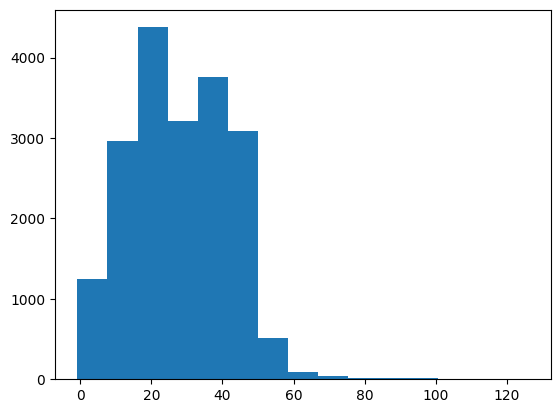

In [15]:
edge_counter = Counter()

imp_org = [
    "European Union (EU)",
    "North Atlantic Treaty Organization (NATO)",
    "Shanghai Cooperation Organisation (SCO)",
    "BRICS",
    "G7",
    "G20",
    "Non-Aligned Movement (NAM)",
    "Organization of Islamic Cooperation (OIC)",
    "G77"
]

for org_name, members in organizations.items():
    if org_name in imp_org:
        org_weight = 10 / len(members) * 3
    else:
        org_weight = 10 / len(members)
    for pair in combinations(members, 2):
        edge_counter[pair] += org_weight*10

for members in votings.values():
    for pair in combinations(members, 2):
        edge_counter[pair] += 0.01

for i, country_i in enumerate(countries):
    for j in range(i+1, len(countries)):
        country_j = countries[j]
        similarity = sim_matrix[i][j]
        edge_counter[(country_i, country_j)] += similarity

plt.hist(dict(edge_counter).values(), bins=15)

G = nx.Graph()
for (u, v), w in edge_counter.items():
    G.add_edge(u, v, weight=w)

countries_to_remove = [
    "Serbia", "Cook Islands", "Ivory Coast", 
    "The Bahamas", "The Gambia", "Republic of Ireland"
]

G.remove_nodes_from(countries_to_remove)

node2vec = Node2Vec(G, dimensions=128, walk_length=40, num_walks=300, 
                    p=1, q=0.25, weight_key='weight', workers=2)

model = node2vec.fit(window=10, min_count=1, batch_words=4)

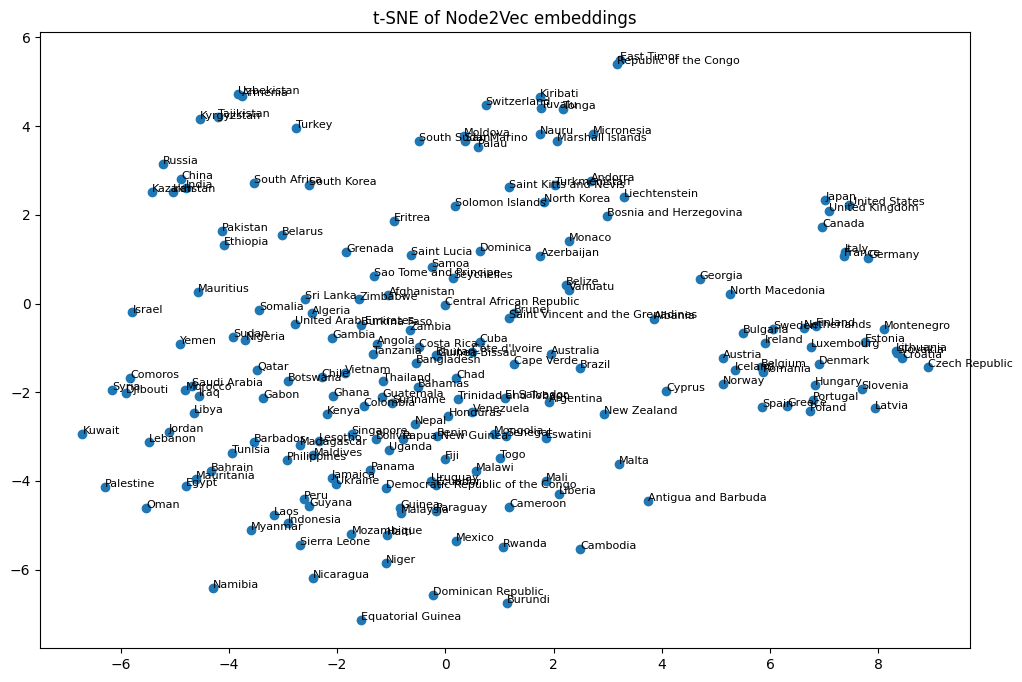

In [16]:
vecs = np.array([model.wv[country] for country in model.wv.index_to_key])
labels = model.wv.index_to_key

tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(vecs)

plt.figure(figsize=(12, 8))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1])

for i, label in enumerate(labels):
    plt.annotate(label, (emb_2d[i, 0], emb_2d[i, 1]), fontsize=8)

plt.title("t-SNE of Node2Vec embeddings")
plt.show()

In [17]:
def get_organizations(country: str):
    return [igo for igo, members in organizations.items() if country in members]

In [18]:
df = pd.read_csv("/kaggle/input/better-speech-embeddings/country_embeddings_optimized.csv").transpose()
df2 = pd.read_csv("/kaggle/input/2-hour-speech-embedding-average-5200-speeches/my_file.csv")
df.columns = df2.columns
df.drop('Unnamed: 0', inplace=True)
df.index = range(0, 4096)

df = df.drop(columns=['Holy See (Vatican City State)'])
df = df.rename(columns={'Viet Nam': 'Vietnam',
                        'Brunei Darussalam': 'Brunei',
                        'Iran, Islamic Republic of': 'Iran',
                        "Lao People's Democratic Republic": 'Laos',
                        'Türkiye': 'Turkey',
                        'Syrian Arab Republic': 'Syria',
                        'Russian Federation': 'Russia',
                        'Palestine, State of': 'Palestine',
                        'Korea, Republic of': 'South Korea',
                        "Korea, Democratic People's Republic of": 'North Korea',
                        'Bolivia, Plurinational State of': 'Bolivia',
                        'Moldova, Republic of': 'Moldova',
                        'Tanzania, United Republic of': 'Tanzania',
                        'Micronesia, Federated States of':'Micronesia',
                        'Venezuela, Bolivarian Republic of': 'Venezuela',
                        'Cabo Verde':'Cape Verde',
                        'Timor-Leste': 'East Timor',
                        'Congo, The Democratic Republic of the': 'Democratic Republic of the Congo',
                        'Czechia': 'Czech Republic',
                        'Congo': 'Republic of the Congo'})
for i in df.columns:
    if not i in list(model.wv.key_to_index.keys()):
        print(i)

print("In model")
for i in list(model.wv.key_to_index.keys()):
    if not i in df.columns:
        print(i)

In model


In [19]:
#df = df.drop(columns=['Bolivia, Plurinational State of', 'Brunei Darussalam'])
countries = list(df.columns)
graph_data = []
speech_data = []
for country in countries:
    graph_data.append(list(model.wv[country]))
    speech_data.append(list(df[country]))

graph_data = np.array(graph_data)
speech_data = np.array(speech_data)

# Combining speech embeddings and knowledge based embeddings

In [20]:
class AttentionFusion(nn.Module):
    """
    Attention-based fusion that learns how to combine speech and graph embeddings
    
    Key differences from VectorInjector:
    1. Uses BOTH speech and graph embeddings as input
    2. Learns which parts of each embedding are most important
    3. Allows embeddings to "talk to each other" through attention
    """
    def __init__(self, speech_dim=4096, graph_dim=128, output_dim=512):
        super().__init__()
        self.speech_proj = nn.Linear(speech_dim, output_dim)
        self.graph_proj = nn.Linear(graph_dim, output_dim)
        
        # Cross-attention: speech queries graph knowledge
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=output_dim, 
            num_heads=8,
            batch_first=True
        )
        
        # Self-attention: refine the fused representation
        self.self_attention = nn.MultiheadAttention(
            embed_dim=output_dim,
            num_heads=8, 
            batch_first=True
        )
        
        self.gate_network = nn.Sequential(
            nn.Linear(output_dim * 2, output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, 2), 
            nn.Softmax(dim=-1)
        )
        
        self.output_proj = nn.Linear(output_dim, output_dim)
        self.layer_norm = nn.LayerNorm(output_dim)
        
    def forward(self, speech_emb, graph_emb):
        batch_size = speech_emb.size(0)
        
        speech_proj = self.speech_proj(speech_emb)
        graph_proj = self.graph_proj(graph_emb)
        
        speech_seq = speech_proj.unsqueeze(1) 
        graph_seq = graph_proj.unsqueeze(1) 
        
        attended_speech, attention_weights = self.cross_attention(
            query=speech_seq,
            key=graph_seq,
            value=graph_seq 
        )
        attended_speech = attended_speech.squeeze(1)
        
        # Combine original and attended information
        combined = torch.cat([speech_proj, attended_speech], dim=-1)
        
        # Learned gating: how much to trust each source
        gate_weights = self.gate_network(combined)  # [batch, 2]
        
        # Apply gating
        gated_speech = gate_weights[:, 0:1] * speech_proj
        gated_graph = gate_weights[:, 1:2] * attended_speech
        fused = gated_speech + gated_graph
        
        # Self-attention for refinement
        fused_seq = fused.unsqueeze(1)
        refined, _ = self.self_attention(fused_seq, fused_seq, fused_seq)
        refined = refined.squeeze(1)
        
        # Final output with residual connection
        output = self.output_proj(refined)
        output = self.layer_norm(output + fused)  # Residual connection
        
        return output

# --- 2. Distance Matrix Function (Euclidean) ---
def euclidean_distance_matrix(vectors):
    return torch.cdist(vectors, vectors, p=2)  # shape (N x N)

# --- 3. Matrix Loss Function ---
def matrix_distance_loss(pred_vectors, target_matrix):
    pred_dists = euclidean_distance_matrix(pred_vectors)
    return F.mse_loss(pred_dists, target_matrix)

# Your data preparation (same as before)
speech_data = np.array(speech_data)  # Your speech embeddings
graph_data = np.array(graph_data)    # Your graph embeddings

# Convert to tensors
speech_tensor = torch.from_numpy(speech_data).float()
graph_tensor = torch.from_numpy(graph_data).float()

# Initialize new model
model = AttentionFusion(
    speech_dim=speech_data.shape[1],
    graph_dim=graph_data.shape[1],
    output_dim=512
)

# Your UMAP target computation (same as before)
graph_umap = umap.UMAP(n_components=100, random_state=42).fit_transform(graph_data)
umap_dists = squareform(pdist(graph_umap, metric='euclidean'))
target_matrix = torch.tensor(umap_dists, dtype=torch.float32)

# Training loop
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(500):
    optimizer.zero_grad()
    
    # Forward pass with BOTH embeddings
    transformed = model(speech_tensor, graph_tensor)
    
    # Your loss computation (same as before)
    loss = matrix_distance_loss(transformed, target_matrix)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 25 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Epoch 0, Loss: 16.564806
Epoch 25, Loss: 0.201131
Epoch 50, Loss: 0.121757
Epoch 75, Loss: 0.095589
Epoch 100, Loss: 0.075694
Epoch 125, Loss: 0.057015
Epoch 150, Loss: 0.042295
Epoch 175, Loss: 0.032601
Epoch 200, Loss: 0.023178
Epoch 225, Loss: 0.018704
Epoch 250, Loss: 0.016815
Epoch 275, Loss: 0.012407
Epoch 300, Loss: 0.010247
Epoch 325, Loss: 0.008025
Epoch 350, Loss: 0.022337
Epoch 375, Loss: 0.005606
Epoch 400, Loss: 0.004636
Epoch 425, Loss: 0.003745
Epoch 450, Loss: 0.008010
Epoch 475, Loss: 0.003180


In [21]:
model.eval()

with torch.no_grad():
    speech_emb = torch.tensor(speech_data).float() 
    graph_emb = torch.tensor(graph_data).float()  
    
    fused_output = model(speech_emb, graph_emb)
    
    transformed_speech = fused_output.squeeze(0)

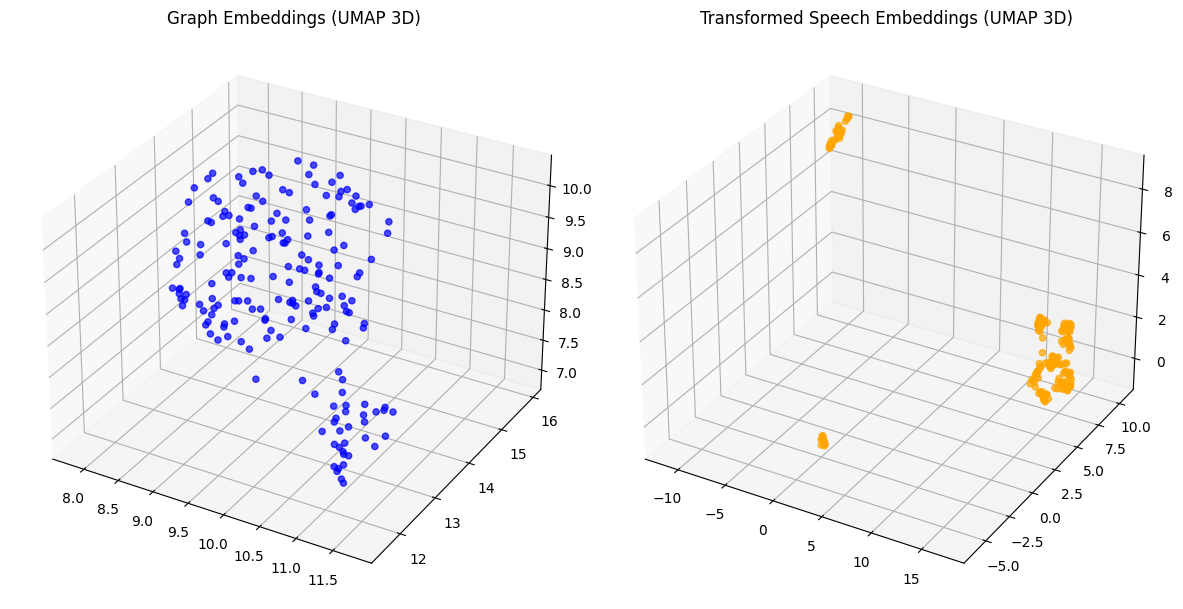

In [22]:
from mpl_toolkits.mplot3d import Axes3D

# Reduce to 3D for plotting
graph_umap_3d = umap.UMAP(n_components=3).fit_transform(graph_data)
transformed_3d = umap.UMAP(n_components=3).fit_transform(transformed_speech)

fig = plt.figure(figsize=(12, 6))

# --- Graph Embeddings ---
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title("Graph Embeddings (UMAP 3D)")
ax1.scatter(graph_umap_3d[:, 0], graph_umap_3d[:, 1], graph_umap_3d[:, 2], c='blue', alpha=0.7)

# --- Transformed Speech Embeddings ---
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title("Transformed Speech Embeddings (UMAP 3D)")
ax2.scatter(transformed_3d[:, 0], transformed_3d[:, 1], transformed_3d[:, 2], c='orange', alpha=0.7)

plt.tight_layout()
plt.show()

In [23]:
combined_embedding = torch.reshape(torch.tensor(transformed_speech), (512, 193))

np_array = combined_embedding.detach().cpu().numpy()
final_country_embeddings = pd.DataFrame(np_array, columns=countries)
final_country_embeddings

/tmp/ipykernel_13/488202115.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  combined_embedding = torch.reshape(torch.tensor(transformed_speech), (512, 193))


,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
0,-0.764020,-0.798525,-1.816481,-0.084558,0.751996,0.784722,-0.492064,-0.544735,0.464941,0.126386,...,0.334026,0.892893,0.370741,-1.479638,0.564170,0.761487,0.017164,-1.012394,0.445560,-0.253129
1,-0.484320,-0.840230,-1.214309,1.138701,0.958576,1.127408,-0.740744,-0.233376,-1.492973,-1.038410,...,0.531035,1.448756,-1.494578,0.732272,-0.765500,-0.607951,1.678559,-0.985567,1.053735,-0.420902
2,-0.390436,0.125260,-1.145471,0.604964,-0.315419,0.541136,0.231113,0.353782,-1.686585,0.013293,...,0.146995,0.511154,-0.800535,0.141689,-1.683322,0.346544,-0.399844,1.251438,-0.234650,-1.387980
3,0.152536,0.356367,0.471989,-0.125299,0.835780,0.587840,-0.628494,-1.932046,0.919340,-0.625865,...,1.328031,0.498916,1.941141,0.886907,1.364893,-0.903649,0.467728,0.394758,1.185940,-0.682318
4,1.448924,-1.237646,0.455788,-0.226594,0.472278,0.310670,-0.853422,0.220728,0.297896,-0.309904,...,-0.763368,-0.001775,0.129320,-0.039047,0.741478,-0.850147,1.154194,0.425242,2.234571,-0.784258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,-0.789887,0.166970,-1.687448,0.449957,-0.417953,1.182234,-0.240491,-1.378948,0.129047,0.354219,...,-1.124259,0.194790,-0.328445,-0.721460,2.226621,0.372417,0.402615,0.289006,1.336305,0.521345
508,1.914131,0.848339,1.374837,-0.933037,0.520007,0.354079,1.167943,-0.664166,1.419292,-1.222299,...,-1.973535,-2.030701,-2.249565,0.069159,-0.047758,-0.140840,-1.241739,-1.037218,-0.806861,-0.071154
509,0.100054,-0.043675,0.694594,-0.826852,1.144041,0.342984,2.228440,-0.768570,-0.311125,-2.022476,...,0.699477,-0.520228,-1.813194,0.521591,1.260349,0.039358,1.287658,-1.019992,-0.603713,-0.259712
510,0.021272,-0.803468,-0.609697,-1.259080,-1.234631,-1.105561,0.787666,0.650686,-0.849904,0.872553,...,-0.754288,1.570017,1.303141,1.274859,0.039982,-0.792969,-0.972627,0.894569,-0.680913,-1.331034


In [24]:
def compare_countries(country1, country2):
    cs = cosine_similarity(
        np.array(list(final_country_embeddings[country1])).reshape(1, -1),
        np.array(list(final_country_embeddings[country2])).reshape(1, -1)
    )
    return cs

# Visualizing and testing

(193, 128) (193, 4096)


Text(0.5, 1.0, 'Correlation Between Policy - Speech Embeddings')

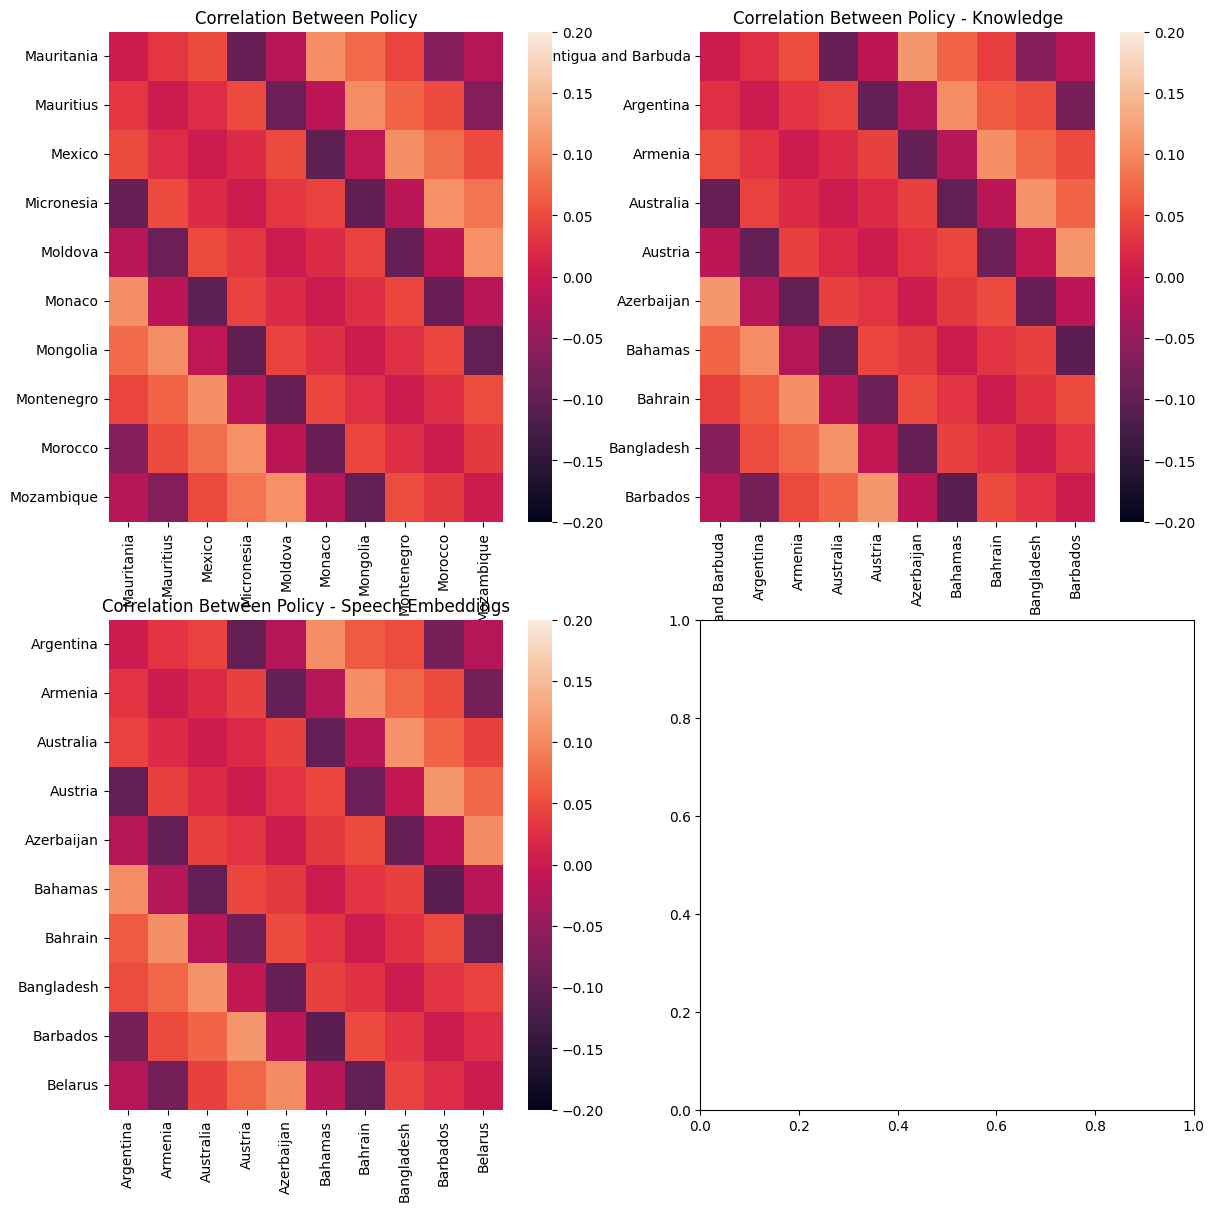

In [25]:
def get_corr_matrix(final_country_embeddings):
    start = random.randint(0, len(final_country_embeddings.columns)-10)
    corr_matrix = pd.DataFrame(
        index=final_country_embeddings.columns[start:start+10],
        columns=final_country_embeddings.columns[start:start+10],
        dtype=float
    )
    for i, country in enumerate(final_country_embeddings.columns[start:start+10]):
        for j, country_2 in enumerate(final_country_embeddings.columns[start:start+10]):
            if j > i:
                sim = compare_countries(country, country_2)
                corr_matrix.loc[country, country_2] = sim
                corr_matrix.loc[country_2, country] = sim
            elif j==i:
                corr_matrix.loc[country, country_2] = 0
    return corr_matrix

corr_matrix = get_corr_matrix(final_country_embeddings)
graph_data = np.array(graph_data)
speech_data = np.array(speech_data)
print(graph_data.shape, speech_data.shape)

graph_df = pd.DataFrame(graph_data.transpose(), columns=countries)
speech_df = pd.DataFrame(speech_data.transpose(), columns=countries)

graph_df = get_corr_matrix(graph_df)
speech_df = get_corr_matrix(speech_df)

fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()

minmax = 0.2

sns.heatmap(corr_matrix, annot=False, vmin=-minmax, vmax=minmax, ax=axes[0])
axes[0].set_title('Correlation Between Policy')

sns.heatmap(graph_df, annot=False, vmin=-minmax, vmax=minmax, ax=axes[1])
axes[1].set_title('Correlation Between Policy - Knowledge')

sns.heatmap(speech_df, annot=False, vmin=-minmax, vmax=minmax, ax=axes[2])
axes[2].set_title('Correlation Between Policy - Speech Embeddings')

In [26]:
umap_model = umap.UMAP(n_components=5, random_state=42)
graph_umap = umap_model.fit_transform(graph_data)
speech_umap = umap_model.fit_transform(final_country_embeddings)
or_speech_umap = umap_model.fit_transform(speech_data)

from scipy.spatial.distance import pdist, squareform

def get_distance_matrix(umap_embeddings, countries, sample_size=5):
    idx = sorted(random.sample(range(len(countries)), sample_size))
    selected = umap_embeddings[idx]
    dist_matrix = squareform(pdist(selected, metric='euclidean'))
    selected_countries = [countries[i] for i in idx]
    df = pd.DataFrame(dist_matrix, index=selected_countries, columns=selected_countries)
    return df

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Text(0.5, 1.0, 'UMAP Distance Between Country Policy Embeddings')

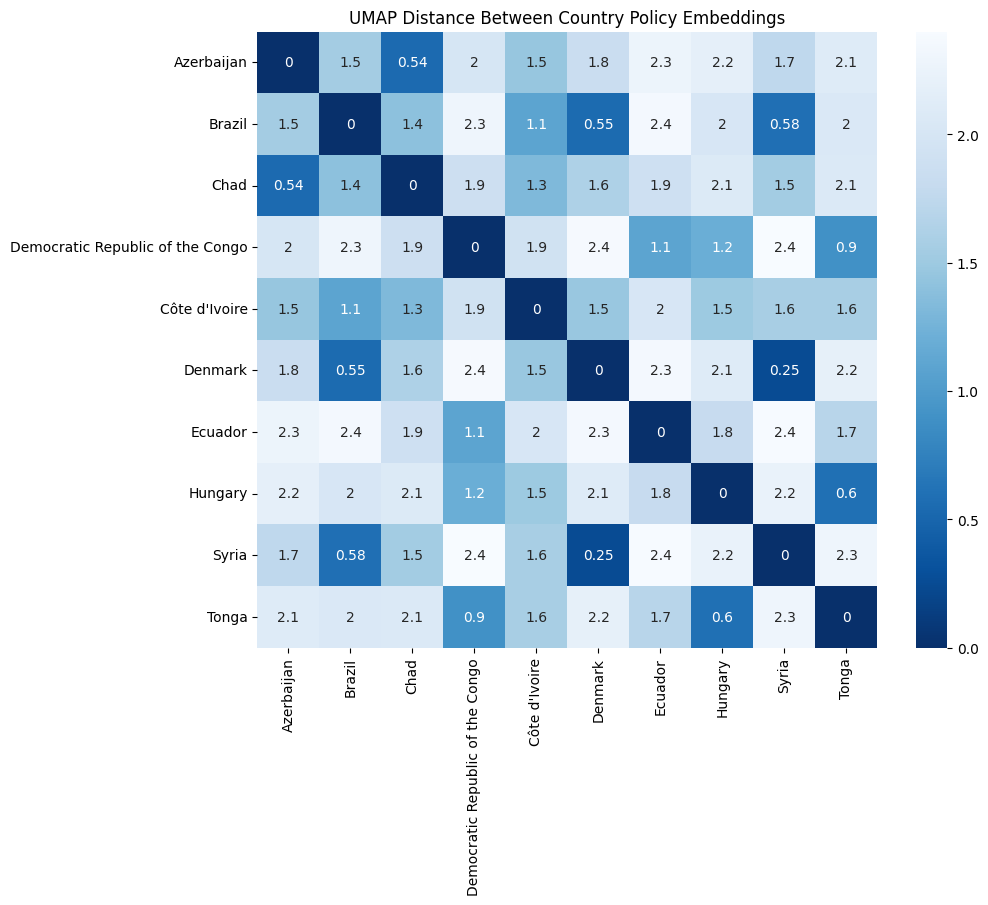

In [27]:
plt.figure(figsize=(10,8))

graph_umap_df = get_distance_matrix(graph_umap, countries, 10)
speech_umap_df = get_distance_matrix(speech_umap, countries, 10)
or_speech_umap_df = get_distance_matrix(or_speech_umap, countries, 10)

sns.heatmap(speech_umap_df, annot=True, vmin=0, vmax=None, cmap="Blues_r")
plt.title('UMAP Distance Between Country Policy Embeddings')

Text(0.5, 1.0, 'UMAP Distance in Knowledge Injection')

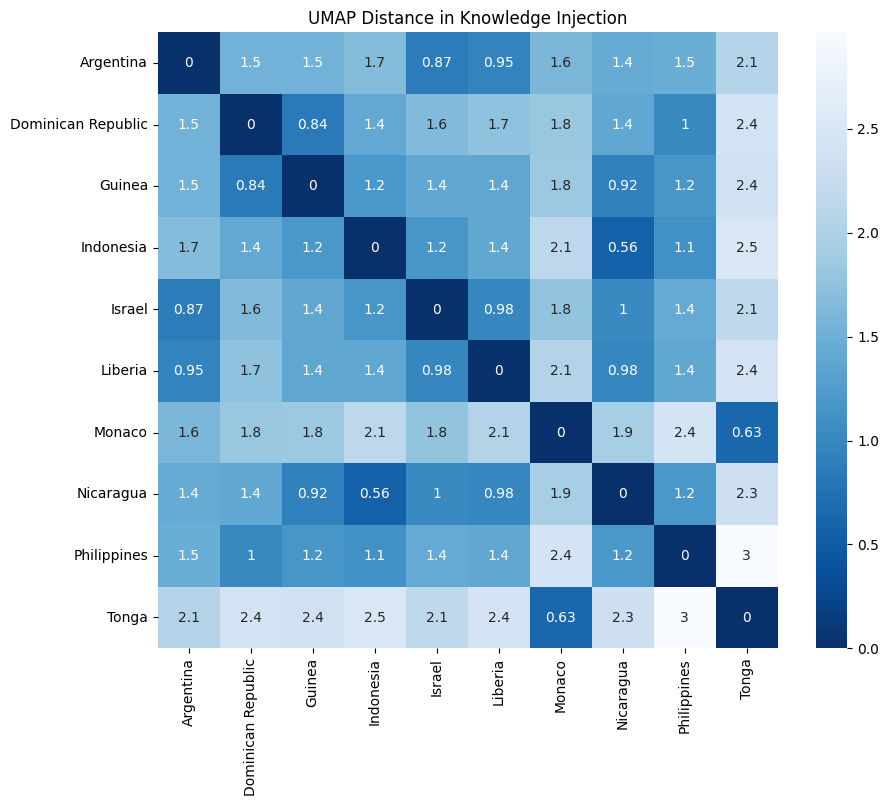

In [28]:
plt.figure(figsize=(10,8))
sns.heatmap(graph_umap_df, annot=True, vmin=0, vmax=None, cmap="Blues_r")
plt.title('UMAP Distance in Knowledge Injection')

Text(0.5, 1.0, 'UMAP Distance in Original Speech Embeddings')

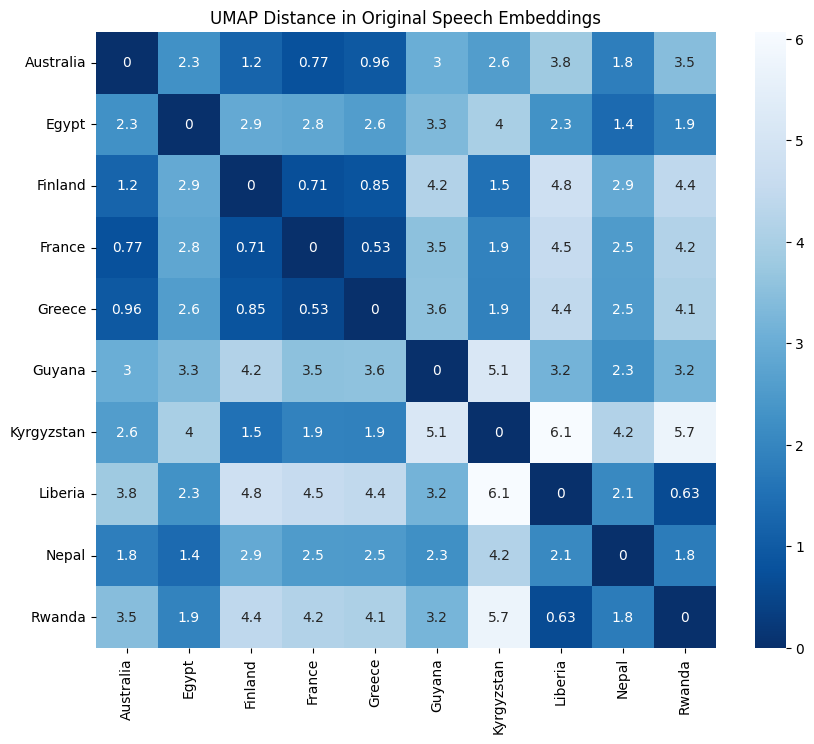

In [29]:
plt.figure(figsize=(10,8))
sns.heatmap(or_speech_umap_df, annot=True, vmin=0, vmax=None, cmap="Blues_r")
plt.title('UMAP Distance in Original Speech Embeddings')

In [30]:
def get_umap_map(umap):
    distances = []
    for i in range(len(countries)):
        dists = [j**2 for j in umap[i]]
        dists = math.sqrt(sum(dists))
        distances.append(dists)
    
    world_map = pd.DataFrame({'country': countries, 'value': distances})
    fig = px.choropleth(world_map,
                    locations="country",         # Can also use 'iso_alpha' (ISO-3 codes)
                    locationmode="country names",# or "ISO-3"
                    color="value",               # The numeric column to color by
                    color_continuous_scale="Cividis",  # Or 'Plasma', 'Cividis', etc.
                    title="World Map by Euclidian Distance of graph")
    
    fig.show()

get_umap_map(speech_umap)

In [31]:
full_umap = get_distance_matrix(graph_umap, countries, 190)

In [32]:
umap_projector = umap.UMAP(n_components=2, random_state=42)

def generate_country_similarity(speech: str, place: str, df):
    clean_speech = clean_text(speech)
    speechs = get_segments(clean_speech)
    or_encode = np.array(generate_embeddings(speechs))
    av_vec = np.mean(or_encode, axis=0)

    av_vec = np.expand_dims(av_vec, axis=0)
    model.eval()

    with torch.no_grad():
        speech_emb = torch.tensor(av_vec).float() 
        graph_emb = torch.tensor(graph_data[list(df.columns).index(place)]).float()  

        speech_emb = torch.reshape(speech_emb, (1,4096))
        graph_emb = torch.reshape(graph_emb, (1,128))
        print(speech_emb.shape, graph_emb.shape)
        fused_output = model(speech_emb, graph_emb)
        
        av_vec = fused_output.squeeze(0)

    country_names = list(final_country_embeddings.columns)
    country_matrix = np.stack([final_country_embeddings[col] for col in country_names])

    all_vectors = np.vstack([av_vec, country_matrix])

    all_umap = umap_projector.fit_transform(all_vectors)
    speech_vec = all_umap[0]
    country_vecs = all_umap[1:]

    dists = euclidean_distances([speech_vec], country_vecs)[0]

    lis = list(zip(dists, country_names))
    sorted_data = sorted(lis, key=lambda x: x[0]) 
    print("\n\nPolicy Alignment Scores (negative natural logarithm):\nPlease be careful comparing alignment scores as it is non-linear\n")
    for dist, country in sorted_data:
        if country == place:
            print(f'\n\n-----{country}------\n\n')
            print(f"{dist:.6f} — {country}")
            if dist < 1.5: print("You did a great job in policy alignment!!!")
            print("\n\n")
        else:
            #print(f"{dist:.6f} — {country}")
            pass
    country_dist_list = [(country, dist) for dist, country in sorted_data]
    countries, values = [], []
    for country, value in country_dist_list:
        countries.append(country)
        values.append(value)
    df = pd.DataFrame({'country': countries, 'value': values})
    print(df.head())

    fig = px.choropleth(df,
                    locations="country",         # Can also use 'iso_alpha' (ISO-3 codes)
                    locationmode="country names",# or "ISO-3"
                    color="value",               # The numeric column to color by
                    color_continuous_scale="Viridis",  # Or 'Plasma', 'Cividis', etc.
                    projection="natural earth",  # Map style
                    title="World Map by Value")

    fig.show()

In [33]:
def get_country_stats(country: str, num: int):
    distances = full_umap[country].copy()
    closest_countries = distances[distances > 0].nsmallest(num)
    print(f"3 closest countries to {country}: (UMAP Euclidian Distance)")
    print(', '.join(closest_countries.keys()))
    print("\n")
    print(f"Socioeconomic statistics of {country} as of 2023")
    country_data = pd.DataFrame(socioeconomic[socioeconomic['countries']==country]).drop(columns=['countries']).rename(columns={'Density\n(P/Km2)': 'Density (P/Km2)'})
    print(''.join(f"   - {column}: {country_data.iloc[0][column]}\n" for column in country_data.columns))

In [34]:
MUN_speeches = pd.read_csv("/kaggle/input/mun-speech-dataset/MUN Speech Testing.csv")
index = random.randint(0, len(MUN_speeches)-1)
print(f"Policy similarities of speech:\n\n{MUN_speeches.loc[index]['Speech']} \n\nFrom delegate of nation: {MUN_speeches.loc[index]['Country']}\n\n")
print(f"\nBasic information about {MUN_speeches.loc[index]['Country']}:\n")
print(f"{MUN_speeches.loc[index]['Country']} is part of the following organizations")
print("".join(f"   - {organization}\n" for organization in get_organizations(MUN_speeches.loc[index]['Country'])))

get_country_stats(MUN_speeches.loc[index]['Country'], 3)

generate_country_similarity(MUN_speeches.loc[index]['Speech'], MUN_speeches.loc[index]['Country'], df)

Policy similarities of speech:

Honorable chair, fellow delegates and most esteemed guests, the delegate of Lithuania is grateful to be here today addressing the practice of organ trafficking, the consequences of fraudulent or misleading claims in medicine as well as accessibility of global primary healthcare. As a country with little to no human trafficking, consistently maintaining a "Tier 1" status (in the U.S. Department of State's Trafficking in Persons Report), Lithuania strongly condemns this grievous violation of human rights and urges that all countries implement full compliance with the minimum standards for eliminating trafficking. Lithuania calls for partnerships between governments, and international organizations to undertake this challenge. Lithuania also advocates for the establishment of stricter international regulations on pharmaceutical advertising and the enforcement of penalties for misinformation that endangers public health. Lastly, Lithuania recognizes the crit

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1, 4096]) torch.Size([1, 128])


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.





Policy Alignment Scores (negative natural logarithm):
Please be careful comparing alignment scores as it is non-linear



-----Lithuania------


1.872850 — Lithuania



         country     value
0        Ecuador  0.261660
1        Morocco  0.275361
2  Côte d'Ivoire  0.346779
3          Nepal  0.355445
4           Peru  0.425939
